# Analysis of Description and Suggest Words *REVISED*

Notebook to analyze text description + suggested words come the closest to NYT headlines for that day (as calculated by running cosine similarity on the text embeddings of both groups). [You’ll manually inspect some posts to define the range of cosine similarity that makes sense the most.]

Revised to reflect that cosine similarity was not compared against each article, but with all the articles from that day

**Author: Audrey Yip**

**Table of Contents**
1. [Read in data](#1)
2. [Process description and suggested words](#2)
3. [Create .csvs and get headline and keyword data](#3)     
4. [Compare lengths of substrings to filter videos](#4)
5. [Get word embeddings and calculate cosine similarity](#5)


<a class="anchor" id="1"></a>
### 1. Read in user data 

In [1]:
import os
import pandas as pd

In [2]:
cwd = os.getcwd()
metadata_dir = f'{cwd}/../pre-processing/metadata-csv'
metadata_files = [file for file in os.listdir(metadata_dir) if "Sec2Gr3_" in file]      # only get metadata files for our group

dataframes = []

for file in metadata_files:
    file_path = os.path.join(metadata_dir, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

print('Total number of videos', len(combined_df))

Total number of videos 24915


In [3]:
# Initial Data filtering
# only take unique videos
df = combined_df.drop_duplicates(subset=['video_id'])

num_unique = len(df)
print('Total number of unique videos', num_unique)

# drop all videos where video_description and suggested_words are NaN
df.dropna(subset=['video_description', 'suggested_words'], how='all', inplace=True)
num_no_sugg_descr = len(df)

print("Without description and suggested words:", num_no_sugg_descr)

# drop all videos not created in US
df = df[df['video_locationcreated'] == 'US']
without_US = len(df)

print("Not Created In US:", without_US)

df


Total number of unique videos 22606
Without description and suggested words: 21752
Not Created In US: 13633


/var/folders/3x/2ycn49s93nq5cl2h1z2tvrh00000gn/T/ipykernel_11558/1466515545.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['video_description', 'suggested_words'], how='all', inplace=True)


,video_id,video_timestamp,video_duration,video_locationcreated,suggested_words,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,video_is_ad,video_stickers,author_username,author_name,author_followercount,author_followingcount,author_heartcount,author_videocount,author_diggcount,author_verified
0,7273221955937914155,2023-08-30T16:56:01,37.0,US,"angels in tibet, angels in tibet dance, angels...",356300.0,5606.0,986.0,2000000.0,Replying to @jade🐉not perfect yet & i made a ...,False,NaN,thebeaulexx,beaulexx,NaN,NaN,NaN,NaN,NaN,False
4,7285397643725983008,2023-10-02T12:23:48,37.0,US,"Dream Academy, angels in tibet, Adela Dream Ac...",142700.0,1373.0,551.0,1000000.0,s/o to dream academy for teaching me how to da...,False,NaN,adelajergova,ADÉLA,NaN,NaN,NaN,NaN,NaN,False
12,7309159185550183723,2023-12-05T12:11:01,95.0,US,NaN,19200.0,5782.0,119.0,256800.0,$25 flights for people with Amazon Student Pri...,False,NaN,carielizabethh,cari,NaN,NaN,NaN,NaN,NaN,False
13,7308541182819175722,2023-12-03T20:12:40,102.0,US,NaN,85600.0,1210.0,9652.0,3900000.0,Replying to @Emily 🌸 today we’re making some D...,False,NaN,nattiejopo,Nattie | new mom & lifestyle,NaN,NaN,NaN,NaN,NaN,True
14,7307649122918567211,2023-12-01T10:30:58,110.0,US,"nattie christmas tree, sad baby beige, Step 2 ...",305900.0,23000.0,34400.0,8500000.0,Let’s give my toddler’s Step 2 my first christ...,False,NaN,nattiejopo,Nattie | new mom & lifestyle,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24907,7286461444554624299,2023-10-05T09:12:29,79.0,US,"university of pittsburgh assignment, Universit...",175000.0,9745.0,3089.0,1300000.0,how is this allowed….. #pitt #foryou #universi...,False,NaN,liliorozco77,Lili,NaN,NaN,NaN,NaN,NaN,False
24911,7285527057394584863,2023-10-02T20:46:05,59.0,US,NaN,25600.0,1494.0,182.0,209800.0,"They might be new to me, but they’ve all been ...",False,NaN,tuindian,The Urban Indian,NaN,NaN,NaN,NaN,NaN,False
24912,7284024264334806315,2023-09-28T19:34:23,29.0,US,"Chipotle, Chipotle Burrito, chipotle is my lif...",287000.0,59200.0,2627.0,4000000.0,CHIPOTLE IS MY LiFeeeeee #chipotle #food #burr...,False,NaN,asianchowdown,asianchowdown,NaN,NaN,NaN,NaN,NaN,False
24913,7284462467290303787,2023-09-29T23:55:02,9.0,US,NaN,40900.0,5961.0,230.0,377200.0,i could make a way cuter video but hiding his ...,False,NaN,roshnirekha_,roshni rekha,NaN,NaN,NaN,NaN,NaN,False


In [4]:
# create new column with just the dates
df['video_date'] = df['video_timestamp'].str[:10]

# access relevant columns
df = df[['video_id', 'video_date', 'video_description', 'suggested_words']]
df.head()

,video_id,video_date,video_description,suggested_words
0,7273221955937914155,2023-08-30,Replying to @jade🐉not perfect yet & i made a ...,"angels in tibet, angels in tibet dance, angels..."
4,7285397643725983008,2023-10-02,s/o to dream academy for teaching me how to da...,"Dream Academy, angels in tibet, Adela Dream Ac..."
12,7309159185550183723,2023-12-05,$25 flights for people with Amazon Student Pri...,NaN
13,7308541182819175722,2023-12-03,Replying to @Emily 🌸 today we’re making some D...,NaN
14,7307649122918567211,2023-12-01,Let’s give my toddler’s Step 2 my first christ...,"nattie christmas tree, sad baby beige, Step 2 ..."


<a class="anchor" id="2"></a>
### 2. Process Description and Suggested Words

In [5]:
import re
from nltk.corpus import stopwords

# load stop_words
stop_words = set(stopwords.words('english'))

# create list of hashtags to omit, we will not expect to find these in headlines
stop_hashtags = ['fyp', 'foryou']

def clean_description(description):
    """
    Helper function, takes video description and splits into words, removes punctuation, emojis and stop words.
    """
    if pd.isna(description):  
        return [] 
    
    # remove numbers from the text
    description = re.sub(r'\d+', '', description)

    # split the description into words
    words = description.split()
    
    # remove punctuation and emojis, make everything lowercase
    cleaned_words = [re.sub(r'[^\w\s]', '', word).lower() for word in words]
    
    # remove stop words and words containing stop hashtags
    cleaned_words = [word for word in cleaned_words if word not in stop_words and not any(stop_tag in word for stop_tag in stop_hashtags)]

    # remove empty strings
    cleaned_words = [word for word in cleaned_words if word]
    
    return cleaned_words

def clean_sugg_words(sugg_words):
    """
    Helper function, takes suggested words and splits into words, converts to lowercase and removes stop words.
    """
    if pd.isna(sugg_words):  
        return [] 
    
    # remove numbers from the text
    sugg_words = re.sub(r'\d+', '', sugg_words)
    
    # split the suggested words into individual words
    words = sugg_words.split(',')
    
    # split each word by white space
    words = [sub_word.strip().lower() for word in words for sub_word in word.split()]

    # convert each word to lowercase and remove  whitespace
    words = [word.strip().lower() for word in words]
    
    # remove stop words
    cleaned_words = [word for word in words if word not in stop_words]
    
    return cleaned_words

In [6]:
# apply helper functions to create new column in dataframe
df['video_keywords'] = df['suggested_words'].apply(clean_sugg_words) + df['video_description'].apply(clean_description)

# filter out videos without keywords
df = df[df['video_keywords'].apply(len) > 0]      

df

/var/folders/3x/2ycn49s93nq5cl2h1z2tvrh00000gn/T/ipykernel_11558/2451469188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['video_keywords'] = df['suggested_words'].apply(clean_sugg_words) + df['video_description'].apply(clean_description)


,video_id,video_date,video_description,suggested_words,video_keywords
0,7273221955937914155,2023-08-30,Replying to @jade🐉not perfect yet & i made a ...,"angels in tibet, angels in tibet dance, angels...","[angels, tibet, angels, tibet, dance, angels, ..."
4,7285397643725983008,2023-10-02,s/o to dream academy for teaching me how to da...,"Dream Academy, angels in tibet, Adela Dream Ac...","[dream, academy, angels, tibet, adela, dream, ..."
12,7309159185550183723,2023-12-05,$25 flights for people with Amazon Student Pri...,NaN,"[flights, people, amazon, student, prime, holi..."
13,7308541182819175722,2023-12-03,Replying to @Emily 🌸 today we’re making some D...,NaN,"[replying, emily, today, making, diy, ornament..."
14,7307649122918567211,2023-12-01,Let’s give my toddler’s Step 2 my first christ...,"nattie christmas tree, sad baby beige, Step 2 ...","[nattie, christmas, tree, sad, baby, beige, st..."
...,...,...,...,...,...
24907,7286461444554624299,2023-10-05,how is this allowed….. #pitt #foryou #universi...,"university of pittsburgh assignment, Universit...","[university, pittsburgh, assignment, universit..."
24911,7285527057394584863,2023-10-02,"They might be new to me, but they’ve all been ...",NaN,"[might, new, theyve, grinding, long, time, inc..."
24912,7284024264334806315,2023-09-28,CHIPOTLE IS MY LiFeeeeee #chipotle #food #burr...,"Chipotle, Chipotle Burrito, chipotle is my lif...","[chipotle, chipotle, burrito, chipotle, life, ..."
24913,7284462467290303787,2023-09-29,i could make a way cuter video but hiding his ...,NaN,"[could, make, way, cuter, video, hiding, face,..."


<a class="anchor" id="3"></a>
### 3. Create .csvs and get headline and keyword data    

In [7]:
from get_nyt_articles_revised import filter_by_date

In [8]:
# helper functions for cleaning df of nyt articles

def split_keywords(text):
    """Split text into individual keywords based on whitespace and punctuation, remove stop words"""
    if pd.isna(text):  # check if text is NaN
        return []  
    
    # split text into individual keywords based on whitespace and punctuation
    keywords = re.findall(r'\b\w+\b', text)

    # remove stop words
    cleaned_words = [word.lower() for word in keywords if word not in stop_words]
    
    return cleaned_words

def clean_headline(text):
    """Split headline into individual words based on whitespace and punctuation, remove stop words"""
    if pd.isna(text):  # check if text is NaN
        return []  
    
    # remove numbers from the text
    text = re.sub(r'\d+', '', text)

    # split text into individual keywords based on whitespace
    keywords = text.split()

    # remove stop words
    cleaned_words = [word.lower() for word in keywords if word not in stop_words]
    
    return cleaned_words


In [9]:
# reset indices for loop
df.reset_index(drop=True, inplace=True)
df

,video_id,video_date,video_description,suggested_words,video_keywords
0,7273221955937914155,2023-08-30,Replying to @jade🐉not perfect yet & i made a ...,"angels in tibet, angels in tibet dance, angels...","[angels, tibet, angels, tibet, dance, angels, ..."
1,7285397643725983008,2023-10-02,s/o to dream academy for teaching me how to da...,"Dream Academy, angels in tibet, Adela Dream Ac...","[dream, academy, angels, tibet, adela, dream, ..."
2,7309159185550183723,2023-12-05,$25 flights for people with Amazon Student Pri...,NaN,"[flights, people, amazon, student, prime, holi..."
3,7308541182819175722,2023-12-03,Replying to @Emily 🌸 today we’re making some D...,NaN,"[replying, emily, today, making, diy, ornament..."
4,7307649122918567211,2023-12-01,Let’s give my toddler’s Step 2 my first christ...,"nattie christmas tree, sad baby beige, Step 2 ...","[nattie, christmas, tree, sad, baby, beige, st..."
...,...,...,...,...,...
13546,7286461444554624299,2023-10-05,how is this allowed….. #pitt #foryou #universi...,"university of pittsburgh assignment, Universit...","[university, pittsburgh, assignment, universit..."
13547,7285527057394584863,2023-10-02,"They might be new to me, but they’ve all been ...",NaN,"[might, new, theyve, grinding, long, time, inc..."
13548,7284024264334806315,2023-09-28,CHIPOTLE IS MY LiFeeeeee #chipotle #food #burr...,"Chipotle, Chipotle Burrito, chipotle is my lif...","[chipotle, chipotle, burrito, chipotle, life, ..."
13549,7284462467290303787,2023-09-29,i could make a way cuter video but hiding his ...,NaN,"[could, make, way, cuter, video, hiding, face,..."


<a class="anchor" id="5"></a>
### 5. Get word embeddings and calculate cosine similarity

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [11]:
# load the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [12]:
#trying sbert

from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

/Users/audreyyip/Desktop/CS 315/Project 2/cs315project2datacollection/.project2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# cosine similarity function, from week 7 notebook
from numpy.linalg import norm

def cosineSimilarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    V1 = np.array(vec1)
    V2 = np.array(vec2)
    cosine = np.dot(V1, V2)/(norm(V1)*norm(V2))
    return cosine

In [17]:
rows = []
total_num_videos = len(df)
uncollected = []

# iterate over each row in the video DataFrame
for index, row in df.iterrows():

    print(f"Processing video {index+1}/{total_num_videos}, video id: {row['video_id']}")

    # get relevant NYT articles using the video date
    nyt_df = filter_by_date(row['video_date'])

    # get relevant keywords and combine lists
    if not nyt_df.empty:
        nyt_df['keywords_cleaned'] = nyt_df['keywords'].apply(split_keywords)
        nyt_df['headline_cleaned'] = nyt_df['headline'].apply(clean_headline)
        nyt_df['nyt_keywords'] = nyt_df['keywords_cleaned'] + nyt_df['headline_cleaned']
        

        # makes a sentence for cosine similarity
        nyt_df['article_sentence'] = nyt_df.apply(lambda row: ' '.join(row['keywords_cleaned'] + row['headline_cleaned']), axis=1)

    else:
        uncollected.append(row)

    # get video embedding
    video_sentence  = video_sentence = ' '.join(row['video_keywords'])
    # video_embedding = sbert_model.encode([video_sentence])[0]   # sbert
    video_embedding = embed([video_sentence])[0]              # universal sentence encoder

    # find cosine similarity for each article 
    max_similarity = -1  # initialize maximums
    max_index = -1
    for index, nyt_row in nyt_df.iterrows():
        cosine_similarities = {}
        # calculate embedding for nyt_sentence
        # nyt_embedding = sbert_model.encode([nyt_row['article_sentence']])[0]   # sbert
        nyt_embedding = embed([nyt_row['article_sentence']])[0]               # universal sentence encoder
    
         # calculate cosine similarity
        cosine_sim = cosineSimilarity(video_embedding, nyt_embedding)

        if cosine_sim > max_similarity:
            max_similarity = cosine_sim
            max_index = index
            top_row = nyt_df.loc[max_index]
    
    print("Index of Maximum Cosine Similarity:", max_index)
    print("Maximum Cosine Similarity:", max_similarity)

    # Jyontika -- remove duplicates from video_keywords and nyt_keywords
    # row['video_keywords'] = list(set(row['video_keywords']))
    # flat_list = list(set(flat_list))
    
    # Process the data and create a new row
    new_row = {
        'video_id': row['video_id'],
        'video_date': row['video_date'],
        'video_keywords': row['video_keywords'],
        'nyt_keywords': top_row['nyt_keywords'],
        # headline, abstract, lead paragraph
        #'nyt_abstract': top_row['abstract'],
        'nyt_headline': top_row['headline'],
        #'nyt_lead_paragraph': top_row['lead_paragraph'],
        'cosine_sim': max_similarity
    }
    
    # append the new row to the list of rows
    rows.append(new_row)

    if index+1 == total_num_videos:
        print("Reached last video ID. Exiting loop.")
        break

print("Done processing!")

# create DataFrame from the list of rows
comparison_df = pd.DataFrame(rows)

Processing video 1/13551, video id: 7273221955937914155
NYT data for 2023-08-30 already in folder

Index of Maximum Cosine Similarity: 3545
Maximum Cosine Similarity: 0.730873
Processing video 2/13551, video id: 7285397643725983008
NYT data for 2023-10-02 already in folder

Index of Maximum Cosine Similarity: 133
Maximum Cosine Similarity: 0.6153873
Processing video 3/13551, video id: 7309159185550183723
NYT data for 2023-12-05 already in folder

Index of Maximum Cosine Similarity: 619
Maximum Cosine Similarity: 0.66910064
Processing video 4/13551, video id: 7308541182819175722
NYT data for 2023-12-03 already in folder

Index of Maximum Cosine Similarity: 305
Maximum Cosine Similarity: 0.6868753
Processing video 5/13551, video id: 7307649122918567211
NYT data for 2023-12-01 already in folder

Index of Maximum Cosine Similarity: 152
Maximum Cosine Similarity: 0.75549686
Processing video 6/13551, video id: 7308598201286937902
NYT data for 2023-12-03 already in folder

Index of Maximum Co

KeyboardInterrupt: 

In [ ]:
# write to csv -- change name!
comparison_df.to_csv('sbert_by_day.csv')

<a class="anchor" id="4"></a>
### 4. Compare lengths of substrings to filter videos

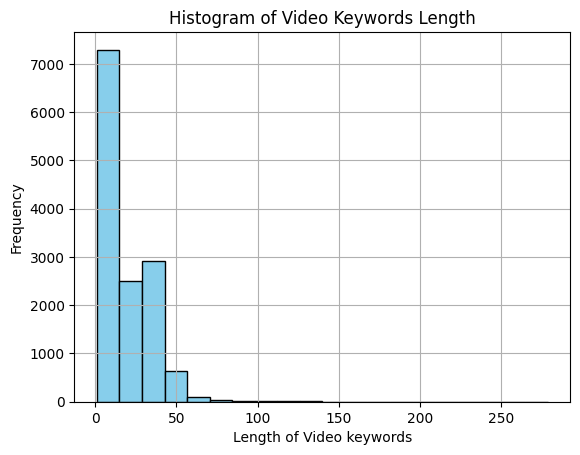

In [ ]:
# create histogram to see nyt keyword lengths
import matplotlib.pyplot as plt

# calculate the length of each string in the 'video_keywords' column
keyword_lengths = comparison_df['video_keywords'].apply(len)

# create a histogram
plt.hist(keyword_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Length of Video keywords')
plt.ylabel('Frequency')
plt.title('Histogram of Video Keywords Length - SBERT, by Day')
# 'Histogram of Video Keywords Length - SBERT, by Week'
plt.grid(True)
plt.show()

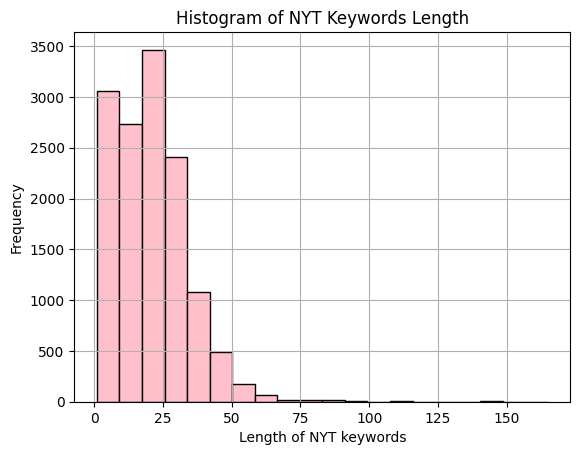

In [ ]:
# calculate the length of each string in the 'nyt_keywords' column
keyword_lengths = comparison_df['nyt_keywords'].apply(len)

# Create a histogram
plt.hist(keyword_lengths, bins=20, color='pink', edgecolor='black')
plt.xlabel('Length of NYT keywords')
plt.ylabel('Frequency')
plt.title('Histogram of NYT Keywords Length')
plt.grid(True)
plt.show()

Mean: 0.26250717
Median: 0.24889457
Standard Deviation: 0.0886044
Minimum Value: 0.046436626
Maximum Value: 0.8288533


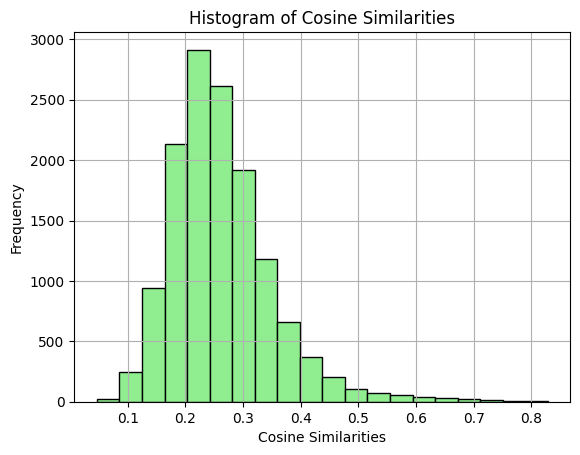

In [ ]:
# inspect cosine similarities
import matplotlib.pyplot as plt

# extracting values from the dictionary
values = comparison_df['cosine_sim']

# calculate summary statistics
mean = np.mean(values)
median = np.median(values)
std_dev = np.std(values)
min_val = np.min(values)
max_val = np.max(values)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

# create histogram
plt.hist(values, bins=20, color='lightgreen', edgecolor='black')
plt.title('Histogram of Cosine Similarities')
plt.xlabel('Cosine Similarities')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
sorted_comparison_df = comparison_df.sort_values(by='cosine_sim', ascending=False).reset_index(drop=True)

sorted_comparison_df

,video_id,video_date,video_keywords,nyt_keywords,cosine_sim
0,7288050618646760746,2023-10-09,"[hamas, fighters, ran, israeli, towns, unalivi...","[kibbutz, movement, israel, gaza, war, 2023, h...",0.828853
1,7297432141485444394,2023-11-03,"[addressing, zionist, argument, hamas, terrori...","[hezbollah, nasrallah, hassan, israel, hamas, ...",0.795867
2,7289062495493541166,2023-10-12,"[eras, tour, movie, taylor, swift, taylor, swi...","[swift, taylor, taylor, swift, the, eras, tour...",0.795216
3,7291688132611722526,2023-10-19,"[trumps, former, lawyer, maga, loyalist, sidne...","[georgia, criminal, case, against, trump, 2020...",0.762126
4,7291125304347643179,2023-10-17,"[israel, gaza, israelhamaswar]","[israel, gaza, war, 2023, israel, gaza, strip,...",0.756661
...,...,...,...,...,...
13546,7287744987834387758,2023-10-08,[tbh],"[spelling, bee, game, spelling, bee, forum]",0.068581
13547,7287298165630307627,2023-10-07,"[actually, went, like]","[the, poseidon, adventure, movie, the, sound, ...",0.062807
13548,7290260269585009963,2023-10-15,"[bruh, vorlens]","[books, literature, cartoons, cartoonists, con...",0.061711
13549,7287740629667368223,2023-10-08,[good],"[illegal, immigration, asylum, right, human, r...",0.057350


In [ ]:
# inspect dataframe
top_cosine_sim_rows = []

for video_id, cosine_similarity in top_50_cosine_similarities:
    # filter comparison_df for the current video_id
    comparison_row = comparison_df[comparison_df['video_id'] == video_id]
    video_keywords = comparison_row['video_keywords'].values[0]  # Extract video_keywords
    
    # filter df for the current video_id
    metadata_row = df[df['video_id'] == video_id]
    video_description = metadata_row['video_description'].values[0]  # Extract video_description
    suggested_words = metadata_row['suggested_words'].values[0]  # Extract suggested_words
    
    # Append the extracted data as a dictionary
    top_cosine_sim_rows.append({'video_keywords': video_keywords,
                                'video_description': video_description,
                                'suggested_words': suggested_words})

# Create DataFrame from list of dictionaries
top_cosine_sim_df = pd.DataFrame(top_cosine_sim_rows)
top_cosine_sim_df


,video_keywords,video_description,suggested_words
0,"[coordinated, lap, intended, crushing, video, ...",Replying to @mkeydeez Sam Norton was described...,NaN
1,"[videos, jean, times, see, dth, povs, deaths, ...",#pov you can see how many times youve dodged d...,"Billie Jean, dodge deaths, Dodge, noah jay woo..."
2,"[gaza, shot, vermont, night, calls, brownunive...",Brown University students interrupt comments f...,NaN
3,"[alltogether, like, walpole, film, popular, ev...",When Edward Walpole fell ill and passed away h...,NaN
4,"[josh, granddaughter, games:, hunger, |, catch...",Snows granddaughter definitely had a crush on ...,"snow and granddaughter, snows granddaughter, T..."
5,"[alone, name, like, try, worth, even, car, els...",mrs.im so tired of working - my car isnt even ...,NaN
6,"[calls, lawyer, truthfully, willis, provide, f...",Trump's former lawyer and MAGA loyalist Sidney...,NaN
7,"[averill, division, sports, divisionathlete, c...",the story of why I quit my division 1 sport 🤍 ...,"gabby averill d1 lax, Quitting A Sport, athlet..."
8,"[soldddd, getting, department, mean, like, ess...",i cant do college anymore. what do you MEAN yo...,"caught using ai, ai detector essay, got caught..."
9,"[dog, gflip, jojosbowbows, like, x, chrishell,...",Someone stop Jojo Siwa shes gone mad luv x ‼️😟...,"jojo siwa, g flip, jojo siwa concert, jojo siw..."
